# Cell Specimen Mapping
The cross-session alignment algorithm has been updated and re-run just prior to release 0.13.2 (June 15th, 2017). As a result all cell specimen IDs have changed. We have built a mapping table to help map from previous cell IDs to new cell IDs. The table is available as a `WellKnownFile` and the `BrainObservatoryApi` provides a method for downloading it and loading it as a DataFrame.

Download this file in .ipynb format <a href='cell_specimen_mapping.ipynb'>here</a>.

## Downloading the Mapping Table
The `BrainObservatoryApi` provides a `get_cell_specimen_id_mapping` method for downloading the mapping table as a CSV file. The method requires a file name to save the table to, and will return the table as a DataFrame.

In [1]:
from pathlib import Path

In [2]:
output_dir = '.'

In [4]:
from allensdk.api.queries.brain_observatory_api import BrainObservatoryApi
from six import iteritems

api = BrainObservatoryApi()

table = api.get_cell_specimen_id_mapping(Path(output_dir) / "cell_mapping_table.csv")

table.info()

2023-07-31 19:58:52,031 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/590985414


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   old_cell_id            27124 non-null  int64  
 1   session_A_new_cell_id  18492 non-null  float64
 2   session_B_new_cell_id  17674 non-null  float64
 3   session_C_new_cell_id  16868 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 847.8 KB


## Using the Mapping Table
The cell specimen mapping table contains 4 columns, `old_cell_id`, `session_A_new_cell_id`, `session_B_new_cell_id`, `session_C_new_cell_id`.  In some instances, multiple ROIs that were assigned to a single cell specimen may now be considered distinct cells after reprocessing, so an old cell specimen ID may map to different cell specimens in different sessions.

In [5]:
# Let's assume I did some previous analysis on a cell and
# want to get the new session B id for use with the SDK
old_cell_id = 541484015

session_B_id = int(table[table.old_cell_id == old_cell_id].session_B_new_cell_id)

# Looking at the output of the table I can see that this ID
# was actually split to two cells in reprocessing
table[table.old_cell_id == old_cell_id]

,old_cell_id,session_A_new_cell_id,session_B_new_cell_id,session_C_new_cell_id
26145,541484015,541484807.0,541484807.0,541484807.0


2023-07-31 20:04:18,294 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/540997912
2023-07-31 20:04:42,427 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/540653508


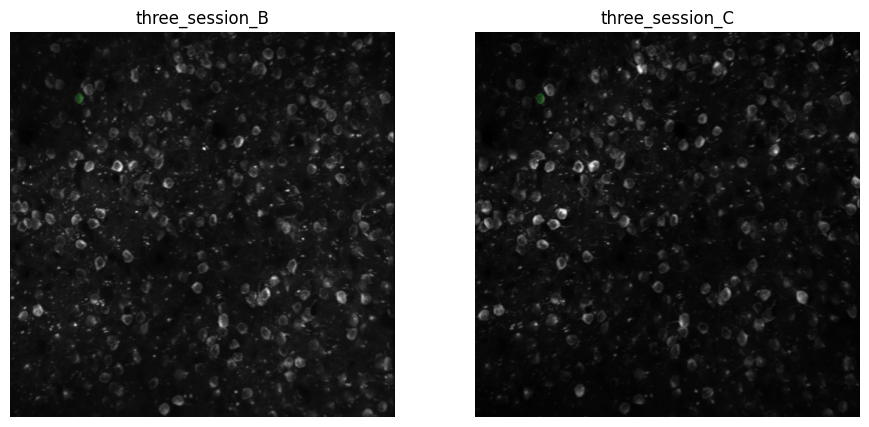

In [6]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import numpy as np
import copy
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

boc =  BrainObservatoryCache(
    manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))

cell_ids = {}
cell_ids["three_session_B"] = int(table[table.old_cell_id == old_cell_id].session_B_new_cell_id)
cell_ids["three_session_C"] = int(table[table.old_cell_id == old_cell_id].session_C_new_cell_id)

datasets = {}
for session, cell_id in iteritems(cell_ids):
    # Find and download the session experiment
    exp = boc.get_ophys_experiments(cell_specimen_ids=[cell_id],
                                    session_types=[session])[0]
    datasets[session] = boc.get_ophys_experiment_data(exp['id'])

# set up a color map for overlay
overlay_map = ListedColormap(["g"])
overlay_map.set_bad(color='k', alpha=0)

# overlay the cell ROIs on the max projection
plt.figure(figsize=(11, 5))
for i, key in enumerate(sorted(datasets.keys())):
    plt.subplot(1, 2, i+1)
    dataset = datasets[key]
    cell_id = cell_ids[key]
    overlay_mask = dataset.get_roi_mask(cell_specimen_ids=[cell_id])[0].get_mask_plane().astype(float)
    overlay_mask[overlay_mask == 0] = np.nan
    plt.imshow(dataset.get_max_projection(), cmap='gray')
    plt.imshow(overlay_mask, cmap=overlay_map, alpha=0.3)
    plt.title(key)
    plt.axis('off')
plt.show()

In [7]:
# I found an interesting cell on the brain observatory website and
# want to see if it's a cell I previously did some analysis on
new_cell_id = 517396395

old_cell_id = int(table[(table.session_A_new_cell_id==new_cell_id) | 
                        (table.session_B_new_cell_id==new_cell_id) |
                        (table.session_C_new_cell_id==new_cell_id)].old_cell_id)

# I can see that this cell is found in all sessions as well.
table[(table.session_A_new_cell_id==new_cell_id) | 
      (table.session_B_new_cell_id==new_cell_id) |
      (table.session_C_new_cell_id==new_cell_id)]

,old_cell_id,session_A_new_cell_id,session_B_new_cell_id,session_C_new_cell_id
19,517394947,517396395.0,517396395.0,517396395.0
